# Hr构建BHZ高对称路径能带图

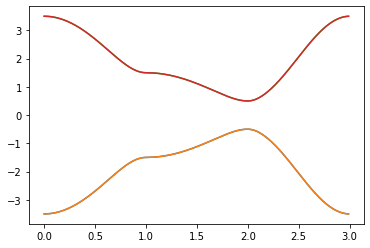

In [54]:
import numpy as np
import matplotlib.pyplot as plt
def Hamhr():
    # ------------------------------------
    file = open('wannier90_hr.dat') # 打开TB模型的数据(通常默认文件名为wannier90_hr.dat)
    comment = file.readline() 
    Band_number = int(file.readline())
    Hopping_number = int(file.readline()) # 对于单独的一个字符串可以将其转化为整数

    degenerate = [] # 用来存储每个hopping的简并度,每个hopping方向对应一个数字
    con = 0
    for line in file: # 接着上面读取到行的位置继续读
        temp = line.strip().split() # 移除字符串头尾指定的字符（默认为空格）,并以空格将这些字符串分开
        t1 = [int(x) for x in temp] #遍历每个字符串并转换为整数
        degenerate.extend(t1) # 数据追加
        if len(degenerate) == Hopping_number: # 当获取的hopping对应的简并度的个数和hopping方向的数目相等的时候,就停止读取文件
            break
    # 接下来读取核心的hr参数,也就是不同带之间hopping的大小以及方向,hr文件中剩下所有的数据都是这些信息,因此可以直接读取到文件末尾
    Hr = []
    for line in file:
        temp = line.strip().split() # 先除去空格,再以空格分立成单独的字符串
        # 将所有的字符串再转化成数值进行存储
        Hr.append([int(temp[0]),int(temp[1]),int(temp[2]),int(temp[3]),int(temp[4]),float(temp[5]),float(temp[6])])
    file.close() # 读取完成之后关闭文件
    Hr = np.array(Hr) # 将一个list转化成矩阵, 这里存储的是核心的hooping方向以及大小

    # 在通过TB数据进行Fourier变换得到动量空间中的模型时,需要利用的hopping R,这里将这些hopping方向R单独提取出来
    Hopping_dir = np.zeros([Hopping_number,3],np.int64)
    for i in range(Hopping_number):
        Hopping_dir[i] = Hr[Band_number**2 * i ,0:3] # 获取所有的hopping方向

    #现在得到了每个轨道hopping方向和对应的大小,那么将其全部存储,方便下一步构建Bloch哈密顿量

    con1 = 0 # 用来计数,工具人
    ham = np.zeros([Hopping_number, Band_number, Band_number], np.complex128)
    for ih in range(Hopping_number):
        for i1 in range(Band_number):
            for i2 in range(Band_number):
                ham[ih,i1,i2] = Hr[con1,5] + 1j*Hr[con1,6] # 对每一个hopping方向,存储每个轨道之间的hopping的大小
                con1 = con1 + 1
    return ham,Hopping_dir,Band_number,Hopping_number
#-------------------------------------------------------------------
def Hamk(hamhr,Hopping_dir,Hopping_number,Band_number,kx,ky):
    # 同过TB数据构建动量空间哈密顿量
    H = np.zeros([Band_number,Band_number],np.complex128) # 动量空间哈密顿量
    for i0 in range(Hopping_number): # 对所有的R求和进行Fourier变换
        H += np.exp(-1j*np.dot(Hopping_dir[i0,0:2],[kx,ky]))*hamhr[i0,:,:] # 每个轨道index对应的前面的位相因子是相同的
    return H
#-------------------------------------------------------------------
def Band_HighSymmetry():
    nx = 100
    vals = []
    klist = []
    for i0 in range(0,nx):
        kx = np.pi*i0/nx
        klist.append(kx/np.pi)
        ham,Hopping_dir,Band_number,Hopping_number = Hamhr()
        H = Hamk(ham,Hopping_dir,Hopping_number,Band_number,kx,0)
        val,vec = np.linalg.eigh(H)
        vals.append(val)
    for i0 in range(0,nx):
        ky = np.pi*i0/nx
        klist.append(1 + ky/np.pi)
        ham,Hopping_dir,Band_number,Hopping_number = Hamhr()
        H = Hamk(ham,Hopping_dir,Hopping_number,Band_number,np.pi,ky)
        val,vec = np.linalg.eigh(H)
        vals.append(val)
    for i0 in range(0,nx):
        ki = np.pi*i0/nx
        klist.append(2 + ki/np.pi)
        ham,Hopping_dir,Band_number,Hopping_number = Hamhr()
        H = Hamk(ham,Hopping_dir,Hopping_number,Band_number,np.pi - ki,np.pi - ki)
        val,vec = np.linalg.eigh(H)
        vals.append(val)
    return klist,vals
#-------------------------------------------------------------------
re1,re2 = Band_HighSymmetry()
plt.plot(re1,re2)

# BHZ高对称路径能带图

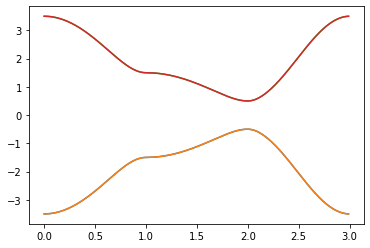

In [55]:
def BHZ(kx,ky):
    m0 = 1.5
    tx = -1.0
    ty = -1.0
    ax = 1.0
    ay = 1.0
    s0 = np.array([[1,0],[0,1]])
    sx = np.array([[0,1],[1,0]])
    sy = np.array([[0,-1j],[1j,0]])
    sz = np.array([[1,0],[0,-1]])
    g1 = np.kron(s0,sz)
    g2 = np.kron(sz,sx)
    g3 = np.kron(s0,sy)
    ham = np.zeros([g1.shape[0],g1.shape[0]],np.complex128)
    ham = (m0 - tx * np.cos(kx) - ty * np.cos(ky))*g1 + ax * np.sin(kx)*g2 + ay * np.sin(ky)*g3
    return ham
#-------------------------------------------------------------------------------------------------
def BHZ_High_path():
    nx = 100
    vals = []
    klist = []
    for i0 in range(0,nx):
        kx = np.pi*i0/nx
        klist.append(kx/np.pi)
        H = BHZ(kx,0)
        val,vec = np.linalg.eigh(H)
        vals.append(val)
    for i0 in range(0,nx):
        ky = np.pi*i0/nx
        klist.append(1 + ky/np.pi)
        H = BHZ(np.pi,ky)
        val,vec = np.linalg.eigh(H)
        vals.append(val)
    for i0 in range(0,nx):
        ki = np.pi*i0/nx
        klist.append(2 + ki/np.pi)
        H = BHZ(np.pi - ki,np.pi - ki)
        val,vec = np.linalg.eigh(H)
        vals.append(val)
    return klist,vals
#-------------------------------------------------------------------------
r1,r2 = BHZ_High_path()
plt.plot(r1,r2)



